 # Network Attack Classification for Task 8.3



 This notebook implements various models for predicting network traffic patterns.

In [40]:
import os
import time
import multiprocessing

import numpy as np
import pandas as pd
from scipy.stats import uniform, loguniform

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


In [41]:
# Configuration
optimise_models = True  # Set to True to perform hyperparameter optimisation
n_jobs = -1  # Use all available cores
n_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0


In [42]:
df = pd.read_csv('Dataset4.csv')
print(f"Rows in dataset: {df.shape[0]}, Columns in dataset: {df.shape[1]}")


Rows in dataset: 123117, Columns in dataset: 84


 ## Data Preprocessing

 Drop rows where target is 'na' or missing

In [43]:
df.dropna(subset=['target'], inplace=True)
df = df[df['target'] != 'na']
print(f"Rows in dataset after dropping missing values: {df.shape[0]}, Columns in dataset after dropping missing values: {df.shape[1]}")


Rows in dataset after dropping missing values: 123115, Columns in dataset after dropping missing values: 84


 There were only two rows with missing values.

 Display the target class counts

In [44]:
# Count and display target classes
print("Number of classes:", df['target'].nunique())
print("\nValue counts for each target class:")
print(df['target'].value_counts())


Number of classes: 12

Value counts for each target class:
target
DOS_SYN_Hping                 94657
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64


 Classes are imbalanced so this needs to be handled

 Check for missing values

In [45]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])



Missing values per column:
id.orig_p               2
id.resp_p               6
proto                   7
service                 2
flow_duration           3
                       ..
idle.avg                4
idle.std                6
fwd_init_window_size    8
bwd_init_window_size    3
fwd_last_window_size    5
Length: 82, dtype: int64


 MIssing values exist so need handling, fill with median for numerical columns

In [46]:
# Handle missing values by filling with median for numerical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())


 One-hot encoding for categorical columns (excluding target)

In [47]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns[categorical_columns != 'target']
df = pd.get_dummies(df, columns=categorical_columns)


 Encode target variable as it is read as a string object

In [48]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])



 Show top correlations with target

In [49]:
correlations = df.corr()['target'].sort_values(ascending=False)
print("\nTop 10 correlations with target:")
print(correlations.head(10))



Top 10 correlations with target:
target                  1.000000
flow_FIN_flag_count     0.408961
service_http            0.372014
fwd_URG_flag_count      0.324307
fwd_init_window_size    0.311414
id.resp_p               0.305569
proto_udp               0.303455
bwd_pkts_payload.std    0.256940
fwd_subflow_pkts        0.243493
bwd_pkts_payload.max    0.226804
Name: target, dtype: float64


 Visualise target distribution to assess how bad the imbalance is

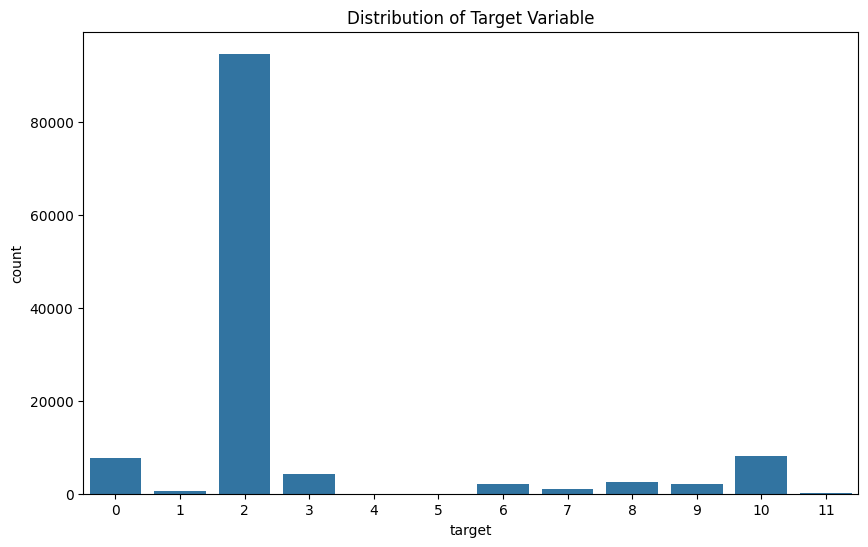

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.show()


 Data is highly imbalanced for class 2

 Show correlation matrix heatmap

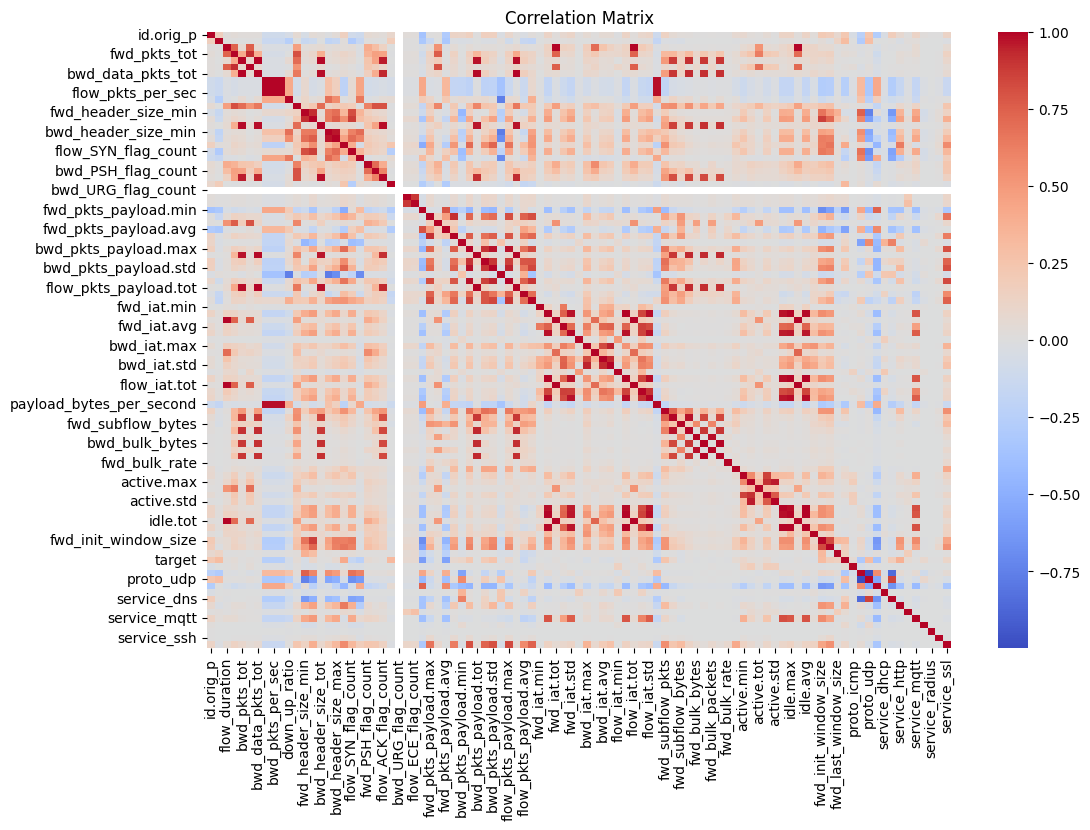

In [51]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


 Some features are highly correlated with each other, future investigation should handle this.

In [52]:
# Prepare features and target
X = df.drop('target', axis=1)
y = df['target'].astype(int)  # Ensure target is integer type


 Scale features

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


 Perform automated feature selection

In [54]:
selector = SelectKBest(f_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()].tolist()
print("\nSelected features:", selected_features)



Selected features: ['fwd_header_size_min', 'fwd_URG_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.avg', 'fwd_iat.max', 'fwd_iat.std', 'flow_iat.max', 'flow_iat.std', 'idle.min', 'idle.max', 'idle.avg', 'fwd_init_window_size', 'bwd_init_window_size', 'fwd_last_window_size', 'proto_tcp', 'proto_udp', 'service_-', 'service_dns', 'service_mqtt', 'service_ssh']


/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 The top 20 features are selected and used for all subsequent models

 Apply SMOTE to handle class imbalance

In [55]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


 Resampling introduced a large number of samples which increased computational complexity. Reduce the size to 1/10th for each class.

In [56]:
print("\nOriginal resampled dataset shape:", X_resampled.shape)

resampled_df = pd.DataFrame(X_resampled)
resampled_df['target'] = y_resampled.astype(int)  # Ensure target is integer type

unique_classes = resampled_df['target'].unique()
reduced_df = pd.DataFrame(columns=resampled_df.columns)

# For each class, take 10% of the samples
for cls in unique_classes:
    class_df = resampled_df[resampled_df['target'] == cls]
    # Use stratified sampling to maintain distribution within each class
    reduced_class_df = class_df.sample(frac=0.1, random_state=42)
    reduced_df = pd.concat([reduced_df, reduced_class_df])

# Shuffle the reduced dataset
reduced_df = reduced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_resampled = reduced_df.drop('target', axis=1).values
y_resampled = reduced_df['target'].values.astype(int)  # Ensure target is integer type

print("Reduced resampled dataset shape:", X_resampled.shape)
print(f"Reduction: {100 * (1 - X_resampled.shape[0] / resampled_df.shape[0]):.2f}% of original size")



Original resampled dataset shape: (1135884, 20)
Reduced resampled dataset shape: (113592, 20)
Reduction: 90.00% of original size


/tmp/ipykernel_196944/3461417652.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reduced_df = pd.concat([reduced_df, reduced_class_df])


 Split the dataset into training and test sets, no need for stratified sampling as the classes are balanced.

In [57]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



Training set shape: (90873, 20)
Test set shape: (22719, 20)


 ## Task 1: Multiple Supervised Learning Models



 Implementing and evaluating ResNet, KNN, and Logistic Regression models. Evaluation is done using f1-score and AUC score.

 Function to evaluate models. f1-score and AUC score are used to assess performance.

In [58]:
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr') if y_pred_proba is not None else None
    return {'F1 Score': f1, 'AUC Score': auc}


 ### Logistic Regression implementation

In [59]:
if optimise_models:
    lr_param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'max_iter': [1000],
        'solver': ['sag']
    }
    lr_grid = GridSearchCV(
        LogisticRegression(random_state=42, solver='sag', n_jobs=n_jobs),
        lr_param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=n_jobs
    )
    lr_grid.fit(X_train, y_train)
    lr_best = lr_grid.best_estimator_
    print("\nLogistic Regression Best Parameters:")
    print(f"C: {lr_grid.best_params_['C']}")
    print(f"max_iter: {lr_grid.best_params_['max_iter']}")
    print(f"solver: {lr_grid.best_params_['solver']}")
else:
    lr_best = LogisticRegression(C=1.0, max_iter=1000, solver='sag', random_state=42, n_jobs=n_jobs)
    lr_best.fit(X_train, y_train)

lr_pred = lr_best.predict(X_test)
lr_pred_proba = lr_best.predict_proba(X_test)

print("\nLogistic Regression Results:")
if optimise_models:
    print("Best parameters:", lr_grid.best_params_)
print(evaluate_model(y_test, lr_pred, lr_pred_proba))


/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick


Logistic Regression Best Parameters:
C: 10
max_iter: 1000
solver: sag

Logistic Regression Results:
Best parameters: {'C': 10, 'max_iter': 1000, 'solver': 'sag'}
{'F1 Score': np.float64(0.848054538473794), 'AUC Score': np.float64(0.9931613003773978)}


/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 The results for LR were quite impressive especially for a simplistic linear model.

 ### KNN implementation

In [60]:
if optimise_models:
    knn_param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    knn_grid = GridSearchCV(
        KNeighborsClassifier(n_jobs=n_jobs),
        knn_param_grid,
        cv=5,
        scoring='f1_weighted',
        n_jobs=n_jobs
    )
    knn_grid.fit(X_train, y_train)
    knn_best = knn_grid.best_estimator_
    print("\nKNN Best Parameters:")
    print(f"n_neighbors: {knn_grid.best_params_['n_neighbors']}")
    print(f"weights: {knn_grid.best_params_['weights']}")
    print(f"metric: {knn_grid.best_params_['metric']}")
else:
    knn_best = KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        metric='euclidean',
        n_jobs=n_jobs
    )
    knn_best.fit(X_train, y_train)

knn_pred = knn_best.predict(X_test)
knn_pred_proba = knn_best.predict_proba(X_test)

print("\nKNN Results:")
if optimise_models:
    print("Best parameters:", knn_grid.best_params_)
print(evaluate_model(y_test, knn_pred, knn_pred_proba))



KNN Best Parameters:
n_neighbors: 3
weights: distance
metric: manhattan

KNN Results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
{'F1 Score': np.float64(0.9910593371882499), 'AUC Score': np.float64(0.9973472549613268)}


 KNN results were spectacular achieving almost perfect results.

 ### ResNet implementation

In [61]:
# ResNet implementation with DataParallel
class ResNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, dropout_rate=0.2):
        super(ResNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(input_dim, hidden_dim)
        
    def forward(self, x):
        identity = self.projection(x)
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.fc2(out)
        out += identity
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out


 ### ResNet implementation

In [62]:
X_train_array = np.array(X_train, dtype=np.float32)
y_train_array = np.array(y_train, dtype=np.int64)
X_test_array = np.array(X_test, dtype=np.float32)
y_test_array = np.array(y_test, dtype=np.int64)

X_train_tensor = torch.from_numpy(X_train_array)
y_train_tensor = torch.from_numpy(y_train_array)
X_test_tensor = torch.from_numpy(X_test_array)
y_test_tensor = torch.from_numpy(y_test_array)


In [63]:
# training loop
if optimise_models:
    # Define hyperparameter grid
    resnet_params = {
        'dropout_rate': [0.1, 0.2, 0.3],
        'learning_rate': [0.001, 0.0005, 0.0001],
        'batch_size': [32, 64, 128]
    }
    
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    
    # Simple grid search with validation split
    for dropout_rate in resnet_params['dropout_rate']:
        for lr in resnet_params['learning_rate']:
            for batch_size in resnet_params['batch_size']:
                print(f"\nTrying parameters: dropout={dropout_rate}, lr={lr}, batch_size={batch_size}")
                
                # Create validation split
                train_size = int(0.8 * len(X_train_tensor))
                indices = torch.randperm(len(X_train_tensor))
                train_indices = indices[:train_size]
                val_indices = indices[train_size:]
                
                X_train_subset = X_train_tensor[train_indices]
                y_train_subset = y_train_tensor[train_indices]
                X_val = X_train_tensor[val_indices]
                y_val = y_train_tensor[val_indices]
                
                # Create data loaders
                train_dataset = TensorDataset(X_train_subset, y_train_subset)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
                val_dataset = TensorDataset(X_val, y_val)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
                
                # Initialize model with fixed hidden_dim=128
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                model = ResNet(X_train_tensor.shape[1], len(np.unique(y_train)), 
                             hidden_dim=128, dropout_rate=dropout_rate).to(device)
                if n_gpus > 1:
                    model = nn.DataParallel(model)
                
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                
                # Training loop
                model.train()
                for epoch in range(5):  # Reduced epochs for faster optimization
                    for batch_X, batch_y in train_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        optimizer.zero_grad()
                        outputs = model(batch_X)
                        loss = criterion(outputs, batch_y)
                        loss.backward()
                        optimizer.step()
                
                # Validation
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        outputs = model(batch_X)
                        val_loss += criterion(outputs, batch_y).item()
                
                val_loss /= len(val_loader)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = {
                        'dropout_rate': dropout_rate,
                        'learning_rate': lr,
                        'batch_size': batch_size
                    }
                    best_model = model.state_dict().copy()
    
    print("\nBest ResNet Parameters:")
    print(f"dropout_rate: {best_params['dropout_rate']}")
    print(f"learning_rate: {best_params['learning_rate']}")
    print(f"batch_size: {best_params['batch_size']}")
    
    # Use best parameters for final training
    model = ResNet(X_train_tensor.shape[1], len(np.unique(y_train)), 
                  hidden_dim=128, dropout_rate=best_params['dropout_rate']).to(device)
    if n_gpus > 1:
        model = nn.DataParallel(model)
    model.load_state_dict(best_model)
    
else:
    # Use default parameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet(X_train_tensor.shape[1], len(np.unique(y_train))).to(device)
    if n_gpus > 1:
        model = nn.DataParallel(model)



Trying parameters: dropout=0.1, lr=0.001, batch_size=32

Trying parameters: dropout=0.1, lr=0.001, batch_size=64

Trying parameters: dropout=0.1, lr=0.001, batch_size=128

Trying parameters: dropout=0.1, lr=0.0005, batch_size=32

Trying parameters: dropout=0.1, lr=0.0005, batch_size=64

Trying parameters: dropout=0.1, lr=0.0005, batch_size=128

Trying parameters: dropout=0.1, lr=0.0001, batch_size=32

Trying parameters: dropout=0.1, lr=0.0001, batch_size=64

Trying parameters: dropout=0.1, lr=0.0001, batch_size=128

Trying parameters: dropout=0.2, lr=0.001, batch_size=32

Trying parameters: dropout=0.2, lr=0.001, batch_size=64

Trying parameters: dropout=0.2, lr=0.001, batch_size=128

Trying parameters: dropout=0.2, lr=0.0005, batch_size=32

Trying parameters: dropout=0.2, lr=0.0005, batch_size=64

Trying parameters: dropout=0.2, lr=0.0005, batch_size=128

Trying parameters: dropout=0.2, lr=0.0001, batch_size=32

Trying parameters: dropout=0.2, lr=0.0001, batch_size=64

Trying paramet

In [64]:
# Train ResNet with final parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 if not optimise_models else best_params['learning_rate'])

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = best_params['batch_size'] if optimise_models else 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

model.train()
for epoch in range(10):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()


In [65]:
# Evaluate ResNet
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    logits = model(X_test_tensor)
    resnet_pred_proba = F.softmax(logits, dim=1).cpu().numpy()  # Convert logits to probabilities
    resnet_pred = np.argmax(resnet_pred_proba, axis=1)

print("\nResNet Results:")
print(evaluate_model(y_test_array, resnet_pred, resnet_pred_proba))



ResNet Results:
{'F1 Score': np.float64(0.8615394288433055), 'AUC Score': np.float64(0.98808716935169)}


 Resnet's results were on par with that of LR.

In [66]:
all_models = {
    'Logistic Regression': (lr_pred, lr_pred_proba),
    'KNN': (knn_pred, knn_pred_proba),
    'ResNet': (resnet_pred, resnet_pred_proba)
}


In [67]:
# All models are compared
model_scores = pd.DataFrame([
    {
        'Model': name,
        'F1 Score': evaluate_model(y_test, pred, pred_proba)['F1 Score'],
        'AUC Score': evaluate_model(y_test, pred, pred_proba)['AUC Score']
    }
    for name, (pred, pred_proba) in all_models.items()
])


 KNN was easily the best performing model.

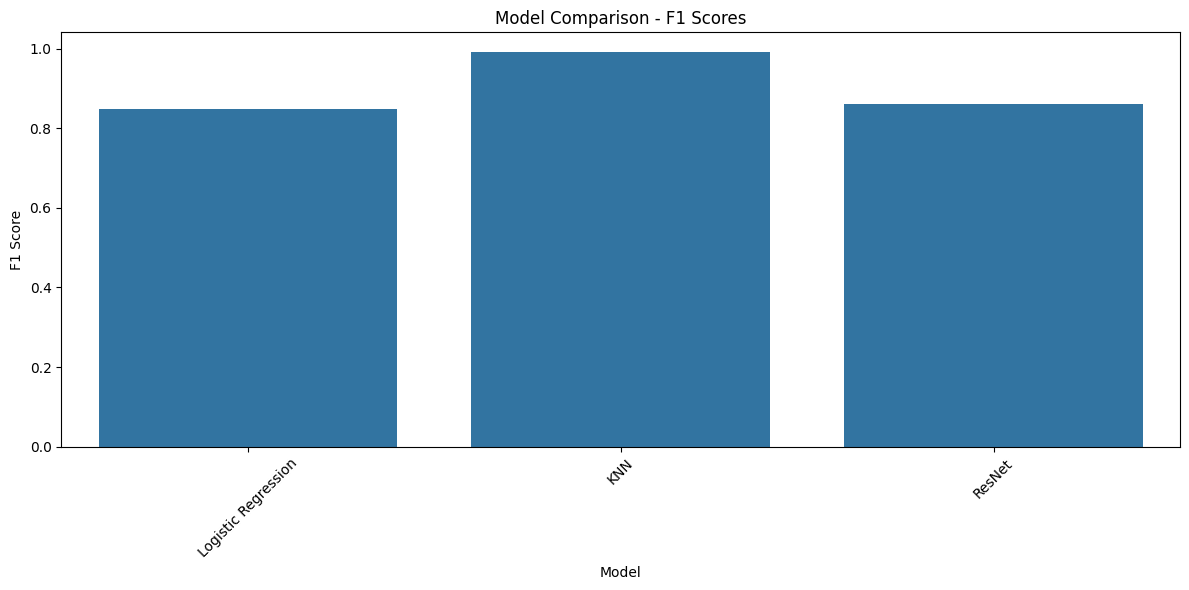

In [68]:
# Plot F1 scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score', data=model_scores)
plt.xticks(rotation=45)
plt.title('Model Comparison - F1 Scores')
plt.tight_layout()
plt.show()


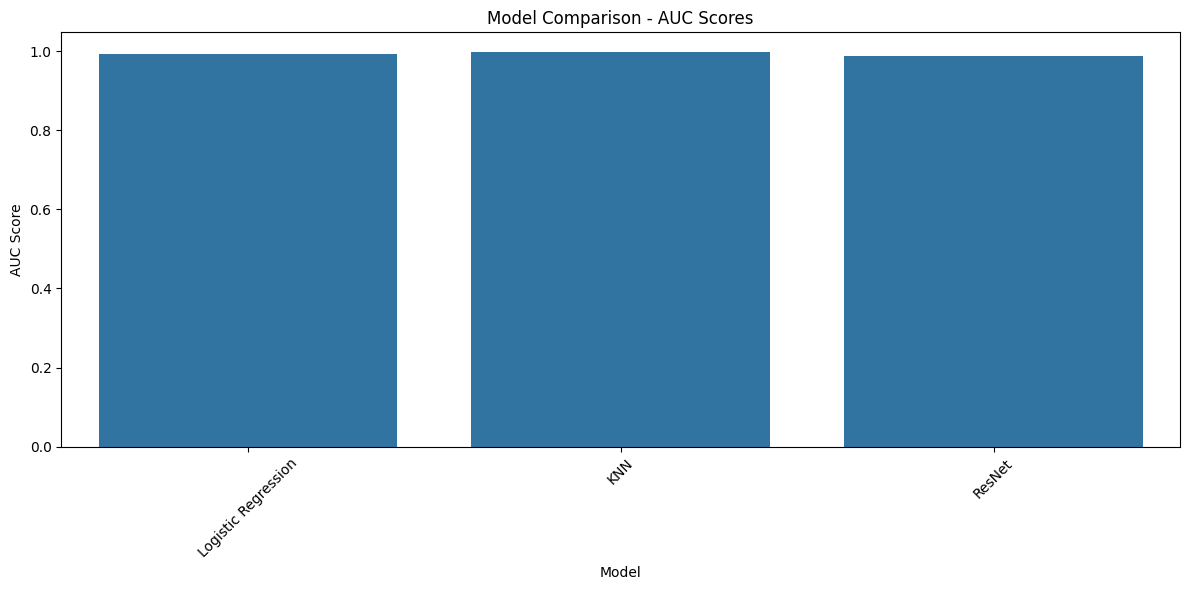

In [69]:
# Plot AUC scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='AUC Score', data=model_scores)
plt.xticks(rotation=45)
plt.title('Model Comparison - AUC Scores')
plt.tight_layout()
plt.show()



 ## Task 2: Most Important Features



 Analyse the feature set to identify the most important features for prediction. Methods used are Random Forest and Permutation Importance.

 ### Method 1: Random Forest Feature Importance


Random Forest Feature Importance:
                 feature  importance
13  fwd_last_window_size    0.104713
3   fwd_pkts_payload.avg    0.103815
1     fwd_URG_flag_count    0.093388
0    fwd_header_size_min    0.090152
2   fwd_pkts_payload.min    0.082787
6           flow_iat.max    0.075531
11  fwd_init_window_size    0.058054
16             service_-    0.055005
4            fwd_iat.max    0.050618
18          service_mqtt    0.047044


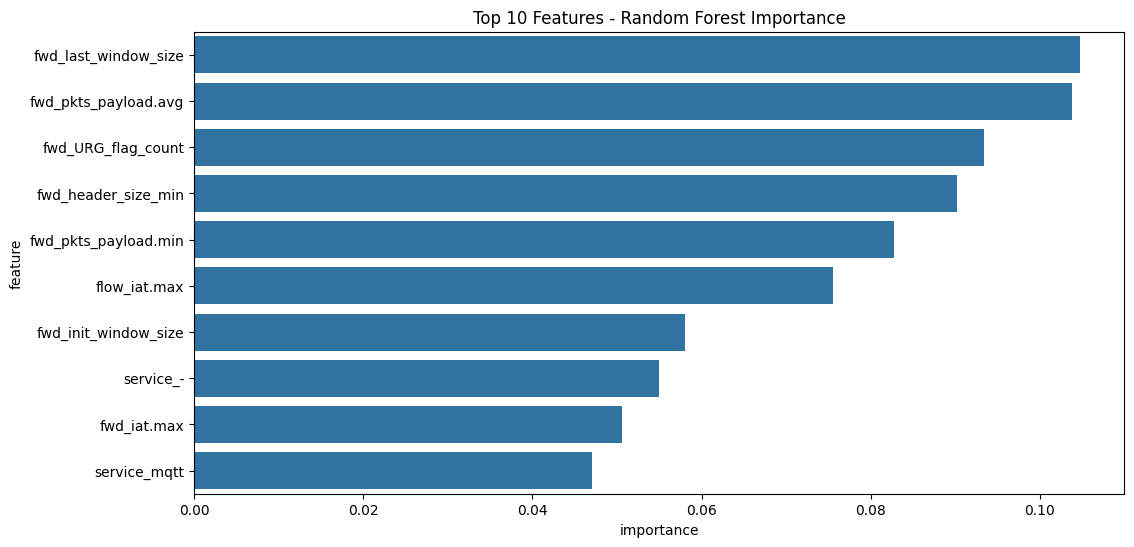

In [70]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=rf_importance.head(10))
plt.title('Top 10 Features - Random Forest Importance')
plt.show()


 The top 6 rank features are clearly the most important features.

 ### Method 2: Permutation Importance


Permutation Feature Importance:
                 feature  importance
1     fwd_URG_flag_count    0.090488
6           flow_iat.max    0.085963
13  fwd_last_window_size    0.081711
18          service_mqtt    0.074391
0    fwd_header_size_min    0.074383
19           service_ssh    0.063009
15             proto_udp    0.058572
16             service_-    0.050183
3   fwd_pkts_payload.avg    0.033303
17           service_dns    0.033188


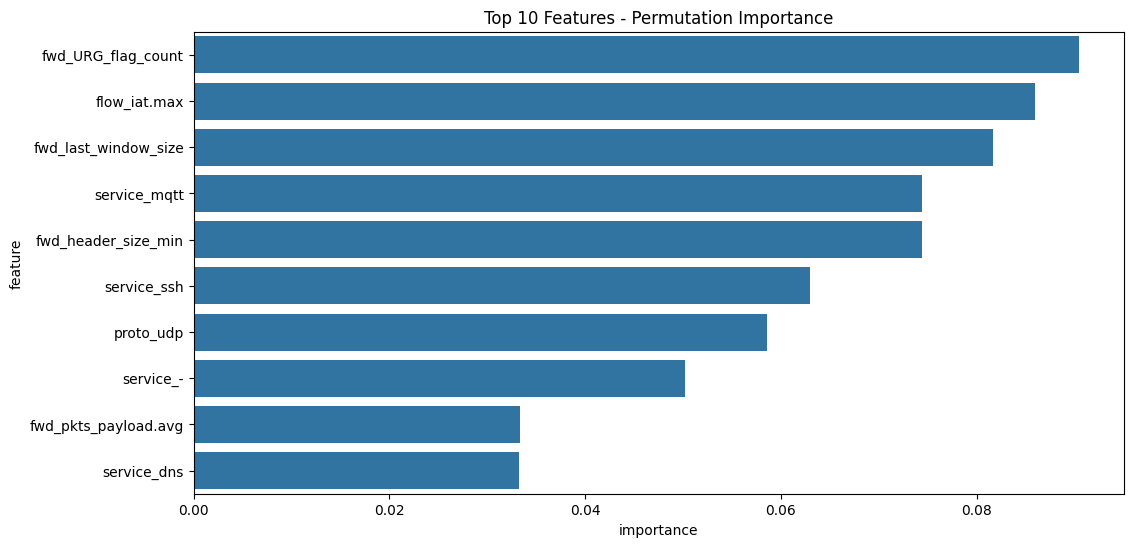

In [71]:
perm_importance = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42
)
perm_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

print("\nPermutation Feature Importance:")
print(perm_importance_df.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=perm_importance_df.head(10))
plt.title('Top 10 Features - Permutation Importance')
plt.show()


 The top 5 rank features are clearly the most important features.

 ### Method 3: Consensus Feature Importance

 Averages the rank of the top 10 features from the Random Forest and Permutation Importance methods.


Consensus Feature Importance (Average Rank):
                 feature  rf_importance  perm_importance  avg_rank
1     fwd_URG_flag_count       0.093388         0.090488       2.0
13  fwd_last_window_size       0.104713         0.081711       2.0
6           flow_iat.max       0.075531         0.085963       4.0
0    fwd_header_size_min       0.090152         0.074383       4.5
3   fwd_pkts_payload.avg       0.103815         0.033303       5.5
18          service_mqtt       0.047044         0.074391       7.0
16             service_-       0.055005         0.050183       8.0
2   fwd_pkts_payload.min       0.082787         0.028311       8.5
11  fwd_init_window_size       0.058054         0.032950       9.0
19           service_ssh       0.037035         0.063009       9.0


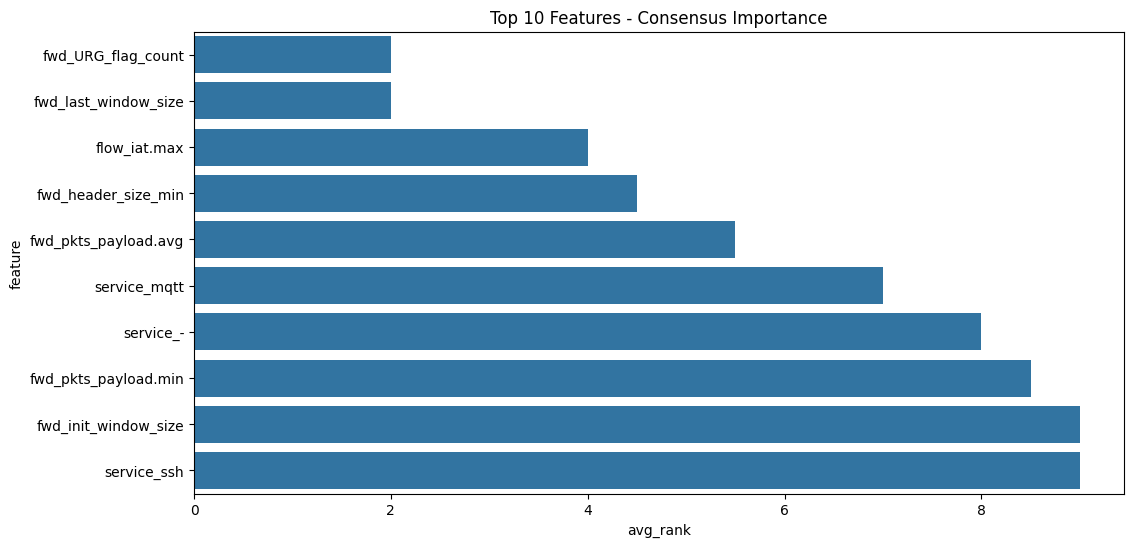

In [72]:
# Compare feature importance across methods
importance_comparison = pd.DataFrame({
    'feature': selected_features,
    'rf_importance': rf_importance['importance'],
    'perm_importance': perm_importance_df['importance']
})

# Calculate average importance rank across methods
importance_comparison['avg_rank'] = importance_comparison[['rf_importance', 'perm_importance']].rank(ascending=False).mean(axis=1)
importance_comparison = importance_comparison.sort_values('avg_rank')

print("\nConsensus Feature Importance (Average Rank):")
print(importance_comparison.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rank', y='feature', data=importance_comparison.head(10))
plt.title('Top 10 Features - Consensus Importance')
plt.show()


 fwd_URG_flag_count and fwd_last_window_size were clearly the most important features.

 ## Task 3: Ensemble Methods

 In this section we create two ensembles to see how it affects the performance of the models.

 ### Ensemble 1: Using existing models

 Existing models are used and stacked using Logistic Regression as the final estimator.

In [73]:
# Ensemble 1: Using existing models
print("\nEnsemble 1 Base Models Performance:")
print("Logistic Regression F1 Score:", evaluate_model(y_test, lr_pred, lr_pred_proba)['F1 Score'])
print("KNN F1 Score:", evaluate_model(y_test, knn_pred, knn_pred_proba)['F1 Score'])

# Create stacking ensemble with LogisticRegression as final estimator
ensemble1 = StackingClassifier(
    estimators=[
        ('lr', lr_best),
        ('knn', knn_best)
    ],
    final_estimator=LogisticRegression(random_state=42, n_jobs=n_jobs),
    cv=5,
    n_jobs=n_jobs
)

# Train the first ensemble
start_time = time.time()
ensemble1.fit(X_train, y_train)
ensemble1_time = time.time() - start_time

# Make predictions
ensemble1_pred = ensemble1.predict(X_test)
ensemble1_pred_proba = ensemble1.predict_proba(X_test)

print("\nEnsemble 1 Results (Stacking with Existing Models):")
print("Training time:", ensemble1_time, "seconds")
print(evaluate_model(y_test, ensemble1_pred, ensemble1_pred_proba))

# Print feature importances from the final estimator
if hasattr(ensemble1.final_estimator_, 'coef_'):
    print("\nStacking Final Estimator Feature Importances:")
    for i, coef in enumerate(ensemble1.final_estimator_.coef_[0]):
        print(f"Feature {i+1} importance: {coef:.4f}")



Ensemble 1 Base Models Performance:
Logistic Regression F1 Score: 0.848054538473794
KNN F1 Score: 0.9910593371882499


/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mick


Ensemble 1 Results (Stacking with Existing Models):
Training time: 100.11184191703796 seconds
{'F1 Score': np.float64(0.9907485045438676), 'AUC Score': np.float64(0.9997162858106372)}

Stacking Final Estimator Feature Importances:
Feature 1 importance: 1.6884
Feature 2 importance: -0.0217
Feature 3 importance: -0.5124
Feature 4 importance: -0.3879
Feature 5 importance: 0.2914
Feature 6 importance: -0.5962
Feature 7 importance: -0.5738
Feature 8 importance: 0.2252
Feature 9 importance: -0.3020
Feature 10 importance: -0.5190
Feature 11 importance: 0.9868
Feature 12 importance: 0.0967
Feature 13 importance: 5.8145
Feature 14 importance: -0.7027
Feature 15 importance: -0.5299
Feature 16 importance: -0.5531
Feature 17 importance: -0.3444
Feature 18 importance: -0.6667
Feature 19 importance: -0.5724
Feature 20 importance: -0.5233
Feature 21 importance: -0.8587
Feature 22 importance: -0.5982
Feature 23 importance: 0.8016
Feature 24 importance: -0.8915


 There was no improvement in the final f1-score of the ensemble over the best performing base model, KNN

 ### Ensemble 2: Using new models

 Three new models are trained using Random Forest, Logistic Regression and SVM. These are then combined using a soft voting classifier.

In [74]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=n_jobs
)

svm = SVC(
    probability=True,
    random_state=42
)

print("\nTraining Ensemble 2 Base Models...")
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)
svm_pred = svm.predict(X_test)
svm_pred_proba = svm.predict_proba(X_test)

print("\nEnsemble 2 Base Models Performance:")
print("Random Forest F1 Score:", evaluate_model(y_test, rf_pred, rf_pred_proba)['F1 Score'])
print("Logistic Regression F1 Score:", evaluate_model(y_test, lr_pred, lr_pred_proba)['F1 Score'])
print("SVM F1 Score:", evaluate_model(y_test, svm_pred, svm_pred_proba)['F1 Score'])

# Create the second ensemble
ensemble2 = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lr', LogisticRegression(random_state=42, n_jobs=n_jobs)),
        ('svm', svm)
    ],
    voting='soft',
    n_jobs=n_jobs
)


start_time = time.time()
ensemble2.fit(X_train, y_train)
ensemble2_time = time.time() - start_time

ensemble2_pred = ensemble2.predict(X_test)
ensemble2_pred_proba = ensemble2.predict_proba(X_test)

print("\nEnsemble 2 Results (New Models):")
print("Training time:", ensemble2_time, "seconds")
print(evaluate_model(y_test, ensemble2_pred, ensemble2_pred_proba))



Training Ensemble 2 Base Models...

Ensemble 2 Base Models Performance:
Random Forest F1 Score: 0.9015317972087113
Logistic Regression F1 Score: 0.848054538473794
SVM F1 Score: 0.8415986568578278


/home/mick/anaconda3/envs/scratch/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Ensemble 2 Results (New Models):
Training time: 123.39636588096619 seconds
{'F1 Score': np.float64(0.8766077161801293), 'AUC Score': np.float64(0.9986212727613576)}


 This ensemble method didnt produce a more predictive model over one of its base models, that being random forest

In [75]:
# %%

 ### Ensemble Comparison

 Both ensembles are compared to see how they perform.


Ensemble Comparison:
          Ensemble  F1 Score  AUC Score  Training Time
0  Existing Models  0.990749   0.999716     100.111842
1       New Models  0.876608   0.998621     123.396366


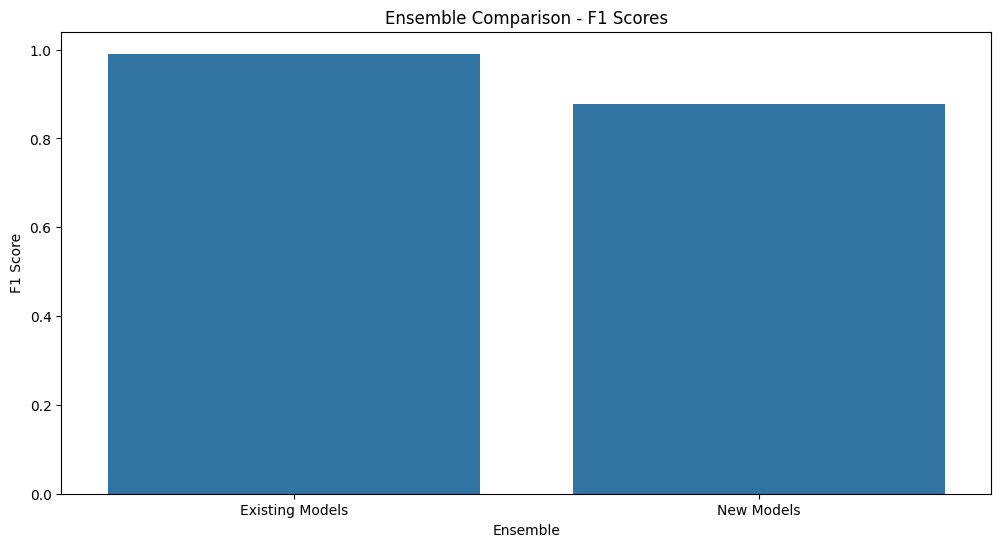

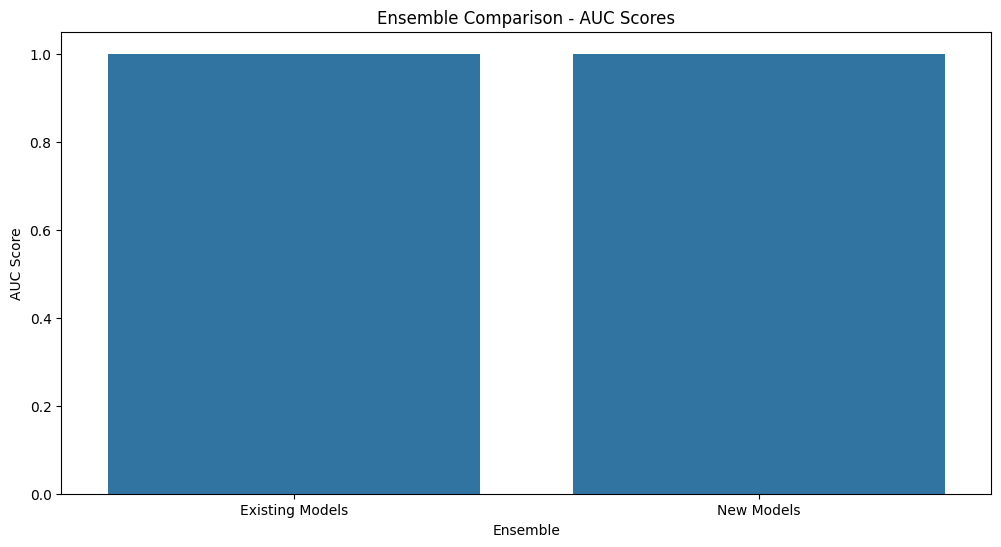

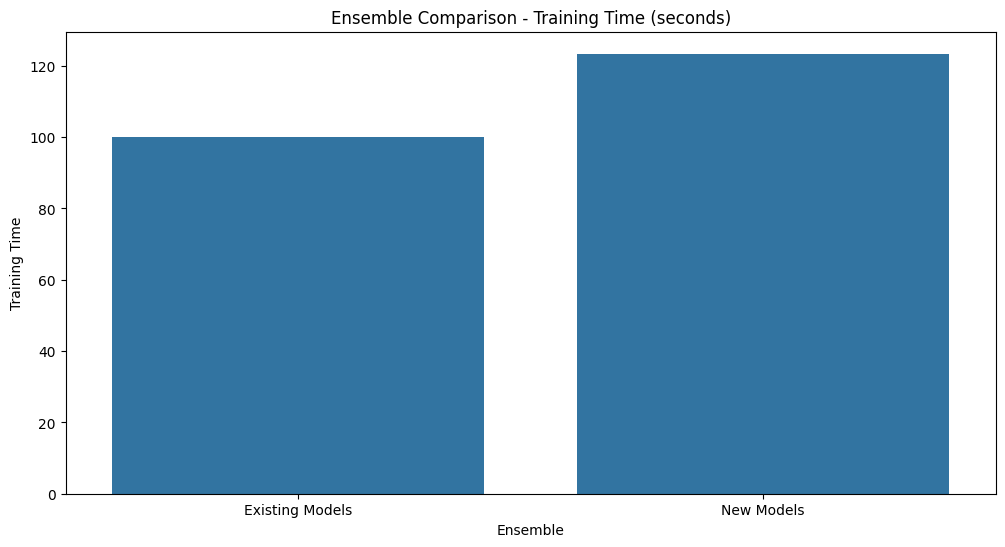

In [76]:
# Compare both ensembles
ensemble_comparison = pd.DataFrame([
    {
        'Ensemble': 'Existing Models',
        'F1 Score': evaluate_model(y_test, ensemble1_pred, ensemble1_pred_proba)['F1 Score'],
        'AUC Score': evaluate_model(y_test, ensemble1_pred, ensemble1_pred_proba)['AUC Score'],
        'Training Time': ensemble1_time
    },
    {
        'Ensemble': 'New Models',
        'F1 Score': evaluate_model(y_test, ensemble2_pred, ensemble2_pred_proba)['F1 Score'],
        'AUC Score': evaluate_model(y_test, ensemble2_pred, ensemble2_pred_proba)['AUC Score'],
        'Training Time': ensemble2_time
    }
])

print("\nEnsemble Comparison:")
print(ensemble_comparison)

plt.figure(figsize=(12, 6))
sns.barplot(x='Ensemble', y='F1 Score', data=ensemble_comparison)
plt.title('Ensemble Comparison - F1 Scores')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Ensemble', y='AUC Score', data=ensemble_comparison)
plt.title('Ensemble Comparison - AUC Scores')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Ensemble', y='Training Time', data=ensemble_comparison)
plt.title('Ensemble Comparison - Training Time (seconds)')
plt.show()


In [77]:
# Compare ensembles with individual models
all_models = {
    'Logistic Regression': (lr_pred, lr_pred_proba),
    'KNN': (knn_pred, knn_pred_proba),
    'ResNet': (resnet_pred, resnet_pred_proba),
    'Ensemble 1 (Existing)': (ensemble1_pred, ensemble1_pred_proba),
    'Ensemble 2 (New)': (ensemble2_pred, ensemble2_pred_proba)
}


In [78]:
# Update model comparison
model_scores = pd.DataFrame([
    {
        'Model': name,
        'F1 Score': evaluate_model(y_test, pred, pred_proba)['F1 Score'],
        'AUC Score': evaluate_model(y_test, pred, pred_proba)['AUC Score']
    }
    for name, (pred, pred_proba) in all_models.items()
])


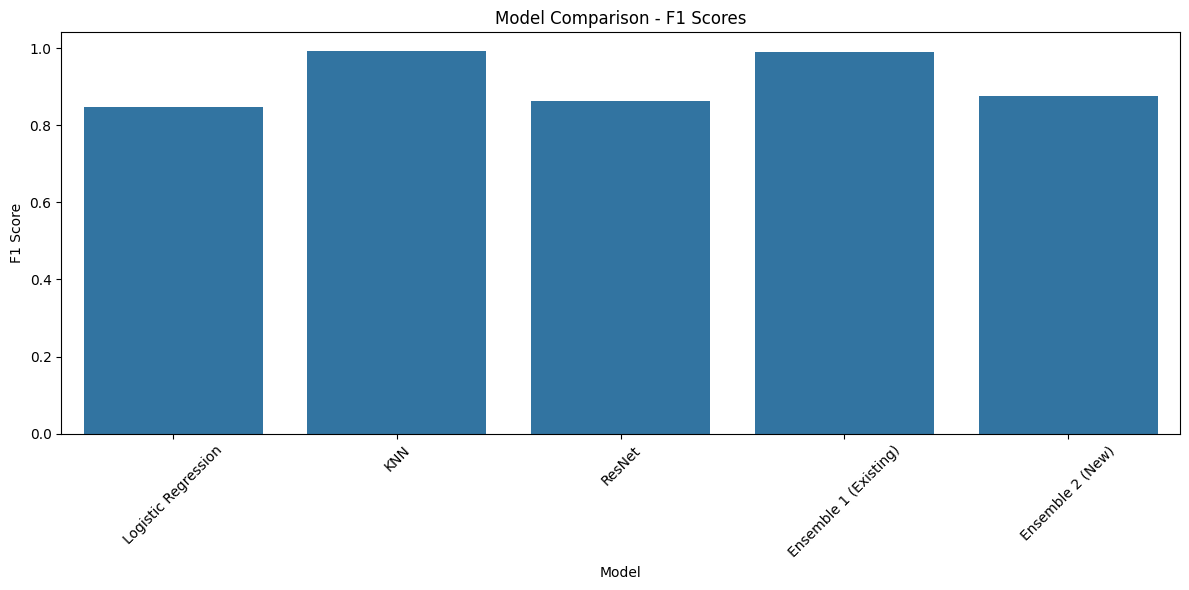

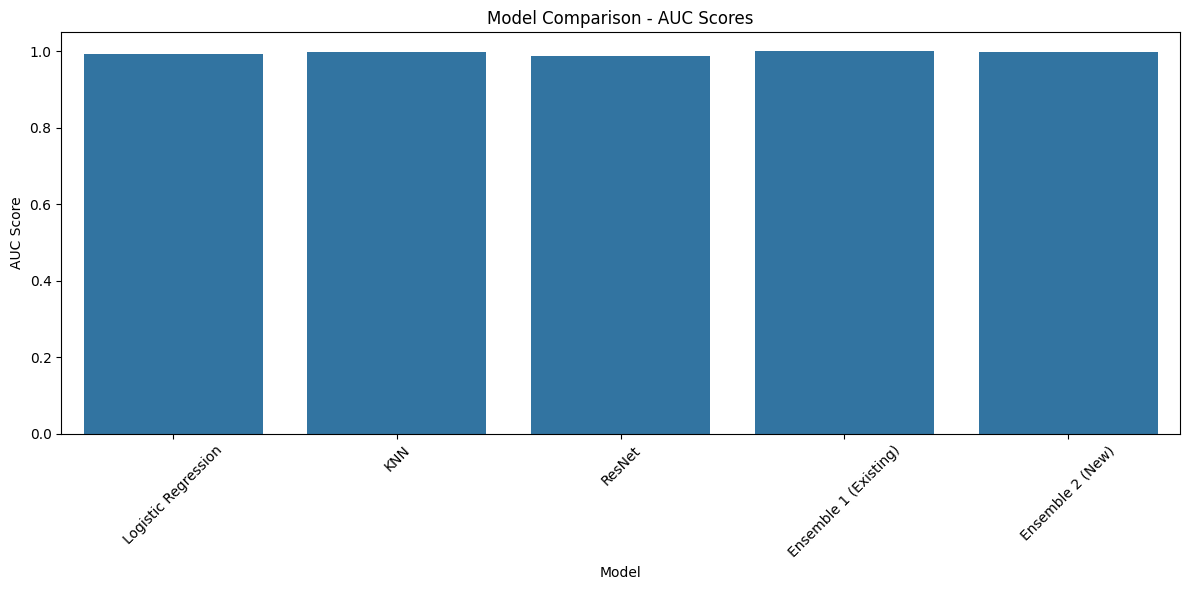

In [79]:
# Plot graphs
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score', data=model_scores)
plt.xticks(rotation=45)
plt.title('Model Comparison - F1 Scores')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='AUC Score', data=model_scores)
plt.xticks(rotation=45)
plt.title('Model Comparison - AUC Scores')
plt.tight_layout()
plt.show()



 ## Task 4: SVM Analysis



 Accessing SVMs for multiclass classification.

In [80]:
start_time = time.time()

svm = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=True,
    random_state=42
)

print("\nTraining SVM model...")
svm.fit(X_train, y_train)
svm_training_time = time.time() - start_time

# Make predictions
svm_pred = svm.predict(X_test)
svm_pred_proba = svm.predict_proba(X_test)

print("\nSVM Results:")
print("Training time:", svm_training_time, "seconds")
print(evaluate_model(y_test, svm_pred, svm_pred_proba))



Training SVM model...

SVM Results:
Training time: 118.50366854667664 seconds
{'F1 Score': np.float64(0.8415986568578278), 'AUC Score': np.float64(0.9809523926156699)}


 SVM performance was on par with the least best classifiers however took a lot of time to train.

In [81]:
# Compare SVM with other models
all_models_with_svm = {
    'Logistic Regression': (lr_pred, lr_pred_proba),
    'KNN': (knn_pred, knn_pred_proba),
    'ResNet': (resnet_pred, resnet_pred_proba),
    'Ensemble 1 (Existing)': (ensemble1_pred, ensemble1_pred_proba),
    'Ensemble 2 (New)': (ensemble2_pred, ensemble2_pred_proba),
    'SVM': (svm_pred, svm_pred_proba)
}


In [82]:
# Update model comparison
model_scores_with_svm = pd.DataFrame([
    {
        'Model': name,
        'F1 Score': evaluate_model(y_test, pred, pred_proba)['F1 Score'],
        'AUC Score': evaluate_model(y_test, pred, pred_proba)['AUC Score']
    }
    for name, (pred, pred_proba) in all_models_with_svm.items()
])


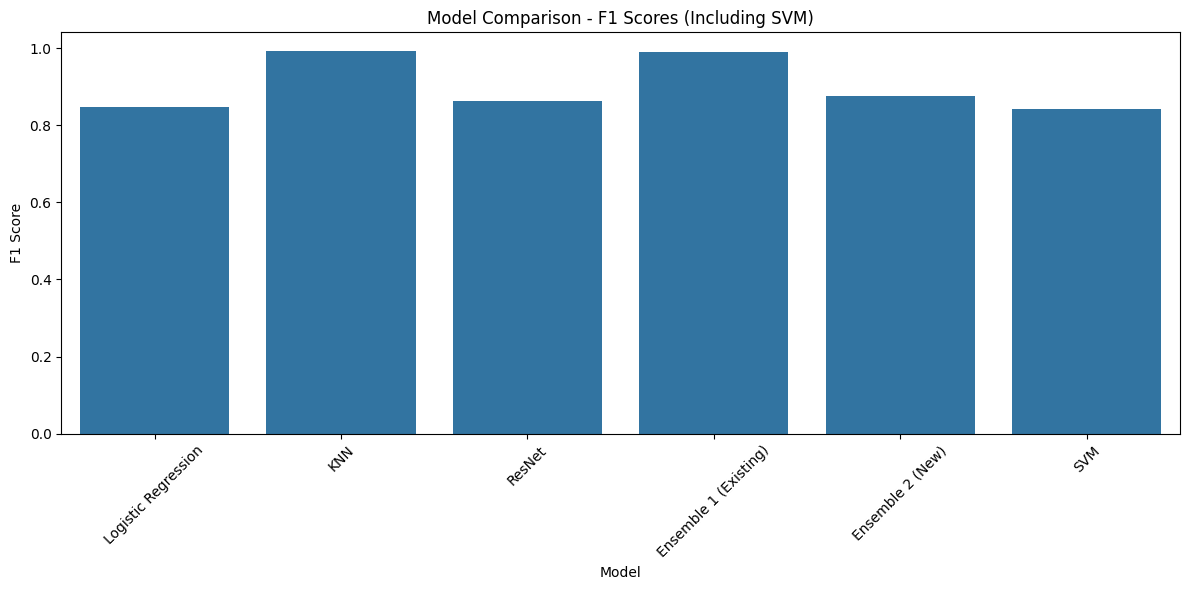

In [83]:
# Plot updated F1 scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score', data=model_scores_with_svm)
plt.xticks(rotation=45)
plt.title('Model Comparison - F1 Scores (Including SVM)')
plt.tight_layout()
plt.show()


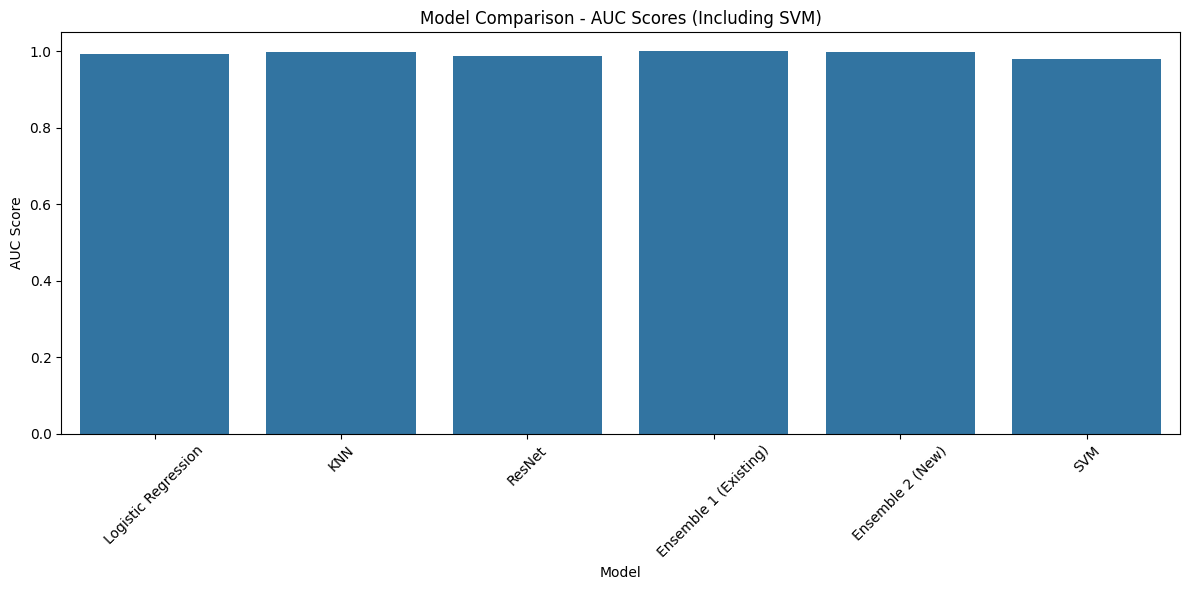

In [84]:
# Plot updated AUC scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='AUC Score', data=model_scores_with_svm)
plt.xticks(rotation=45)
plt.title('Model Comparison - AUC Scores (Including SVM)')
plt.tight_layout()
plt.show()


 Compare all models in a table

In [85]:
performance_data = []
for name, (pred, pred_proba) in all_models_with_svm.items():
    metrics = evaluate_model(y_test, pred, pred_proba)
    performance_data.append({
        'Model': name,
        'F1 Score': f"{metrics['F1 Score']:.4f}",
        'AUC Score': f"{metrics['AUC Score']:.4f}" if metrics['AUC Score'] is not None else 'N/A'
    })

performance_df = pd.DataFrame(performance_data)

performance_df = performance_df.sort_values('F1 Score', ascending=False)

print("\nPerformance Metrics for All Models:")
print("=" * 80)
print(performance_df.to_string(index=False))
print("=" * 80)

print("\nBest Performing Models:")
print(f"Best F1 Score: {performance_df.iloc[0]['Model']} ({performance_df.iloc[0]['F1 Score']})")
print(f"Best AUC Score: {performance_df.loc[performance_df['AUC Score'] != 'N/A', 'Model'].iloc[0]} ({performance_df.loc[performance_df['AUC Score'] != 'N/A', 'AUC Score'].iloc[0]})") 




Performance Metrics for All Models:
                Model F1 Score AUC Score
                  KNN   0.9911    0.9973
Ensemble 1 (Existing)   0.9907    0.9997
     Ensemble 2 (New)   0.8766    0.9986
               ResNet   0.8615    0.9881
  Logistic Regression   0.8481    0.9932
                  SVM   0.8416    0.9810

Best Performing Models:
Best F1 Score: KNN (0.9911)
Best AUC Score: KNN (0.9973)


 The best performing model was KNN.